In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam


class GaussianRBFNetworkC(nn.Module):
    def __init__(self, gaussian_regularizer, centers_regularizer, weights_regularizer, learnable_centers,
                 centers, device='cuda'):
        super(GaussianRBFNetworkC, self).__init__()
class GaussianRBFNetworkC(nn.Module):
    def __init__(self, gaussian_regularizer, centers_regularizer, weights_regularizer, learnable_centers,
                 centers, device='cuda'):
        super(GaussianRBFNetworkC, self).__init__()

        self.device = device
        self.gaussian_regularizer = gaussian_regularizer
        self.centers_regularizer = centers_regularizer
        self.weights_regularizer = weights_regularizer
        self.centers = centers
        self.learnable_centers = learnable_centers
        self.n_centers = centers.shape[0]
        self.n_features = centers.shape[1]
        # Define learnable parameters
        self.precision_elements = nn.Parameter(torch.randn(self.n_features * (self.n_features + 1) // 2)
                                               .to(self.device))
        if self.learnable_centers == True:
            self.centers = nn.Parameter(centers.to(self.device))
        else:
            self.centers_regularizer = 1e-32
        self.weights = nn.Parameter(torch.randn(self.n_centers)
                                    .to(self.device))

    def compute_precision(self, precision_elements):

        lower_tri = torch.zeros((self.n_features, self.n_features)).to(self.device)
        idx = torch.tril_indices(*lower_tri.shape)
        lower_tri[idx[0], idx[1]] = precision_elements
        precision_matrix = torch.matmul(lower_tri, lower_tri.T)
        return precision_matrix

    def forward(self, X):

        precision_matrix = self.compute_precision(self.precision_elements)
        diff = X[:, None, :] - self.centers.unsqueeze(0)
        Phi = torch.exp(-0.5 * torch.einsum('ijk, kl, ijl -> ij', diff, precision_matrix, diff))
        y_hat = torch.sigmoid(Phi @ self.weights)
        return y_hat

    def evaluate_loss(self, y, y_hat):

        bce_loss = nn.BCELoss()
        loss = bce_loss(y_hat, y)
        reg_gaussian = self.gaussian_regularizer * torch.linalg.norm(self.precision_elements)
        reg_centers = self.centers_regularizer * torch.linalg.norm(self.centers)
        reg_weights = self.weights_regularizer * torch.linalg.norm(self.weights)
        loss = loss + reg_gaussian + reg_centers + reg_weights
        return loss

    def feature_importance(self, precision_matrix):

        eigenvalues, eigenvectors = torch.linalg.eigh(precision_matrix)
        feature_importance = torch.matmul(torch.abs(eigenvectors), eigenvalues)
        return feature_importance / torch.sum(feature_importance), eigenvalues, eigenvectors

In [ ]:
# Import necessary libraries
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
# Load the heart attack dataset
data = pd.read_csv('covid_19.csv')

# Preview the dataset
print(data.head())

# Assume the target variable is named 'output' (1 for heart attack, 0 for no heart attack)
# Adjust feature columns based on your dataset
X = data.drop(columns=['Covid_test_result'])  # Features
y = data['Covid_test_result']  # Target variable

# Convert to numpy arrays
X = X.values
y = y.values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Standardize the data
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_st = torch.tensor(X_train_st, dtype=torch.float32)
X_test_st = torch.tensor(X_test_st, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Check the shapes of the tensors
print(X_train_st.shape, y_train.shape)
print(X_test_st.shape, y_test.shape)

   Ind_ID  Cough_symptoms  Fever  Sore_throat  Shortness_of_breath  Headache  \
0       1               1      0            1                    0         0   
1       2               0      1            0                    0         0   
2       3               0      1            0                    0         0   
3       4               1      0            0                    0         0   
4       5               1      0            0                    0         0   

   Known_contact  Test Date  Covid_test_result  
0              1       2020                  0  
1              1       2020                  1  
2              1       2020                  1  
3              1       2020                  0  
4              2       2020                  0  
torch.Size([3961, 8]) torch.Size([3961])
torch.Size([1698, 8]) torch.Size([1698])


In [ ]:
# Determine RBF centers using k-means clustering
#n_centers = 4  # Number of RBF centers
#kmeans = KMeans(n_clusters=n_centers, random_state=0).fit(X_train_st)
#centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)
#learnable_centers=False
#gaussian_reg, centers_reg, weights_reg= 1e-2, None, 1e-5

In [ ]:
import numpy as np
import torch

def fuzzy_c_means(X, num_clusters, m=2, max_iter=100, tol=1e-5):

    # Initialize random membership matrix
    n_samples = X.shape[0]
    u = np.random.rand(n_samples, num_clusters)
    u = u / np.sum(u, axis=1, keepdims=True)

    for iteration in range(max_iter):
        # Calculate the cluster centers
        u_m = u ** m
        centers = (u_m.T @ X) / np.sum(u_m, axis=0)[:, None]

        # Update the membership values
        dist = np.linalg.norm(X[:, None] - centers, axis=2)
        dist = np.fmax(dist, np.finfo(np.float64).eps)  # Prevent division by zero
        u_new = 1.0 / (dist ** (2 / (m - 1)))
        u_new = u_new / np.sum(u_new, axis=1, keepdims=True)

        # Check for convergence
        if np.linalg.norm(u - u_new) < tol:
            break

        u = u_new

    return centers
#print(centers)
#print(centers.shape)
# Generate RBF centers using FCM
X_train_np = X_train_st.numpy()  # Convert to numpy if X_train_st is a PyTorch tensor
n_centers = 16
centers = fuzzy_c_means(X_train_np, num_clusters=n_centers)
centers = torch.tensor(centers, dtype=torch.float32)
print(centers)
print(centers.shape)

tensor([[-0.6444,  0.1066,  0.2126, -0.0702,  3.8882,  0.0287, -0.1352,  0.0000],
        [-1.1023,  2.0436, -0.3365, -0.2043, -0.2239, -0.1088, -2.3455,  0.0000],
        [ 1.4792, -0.4753, -0.3571, -0.2193, -0.2395, -0.1278,  0.4741,  0.0000],
        [-0.7718,  2.0188,  2.7147, -0.1870, -0.1975, -0.0881,  0.3370,  0.0000],
        [-0.7973,  1.1952,  1.8766,  4.0510,  0.0827,  0.2800, -0.9572,  0.0000],
        [ 0.9212, -0.4735, -0.3557, -0.2184, -0.2384, -0.1268,  0.4716,  0.0000],
        [-0.8756,  2.0070, -0.2915, -0.1751, -0.1913, -0.0768, -0.8212,  0.0000],
        [-0.8764,  1.9324, -0.2258, -0.1626,  4.0325, -0.0696, -2.0414,  0.0000],
        [-0.0135, -0.4719, -0.3541, -0.2173, -0.2371, -0.1258,  0.4675,  0.0000],
        [-0.9198, -0.4662, -0.3489, -0.2134, -0.2328, -0.1215,  0.4543,  0.0000],
        [-1.0993,  1.9983, -0.2921,  4.4425, -0.2012, -0.0791, -2.2045,  0.0000],
        [-1.4846, -0.4694, -0.3515, -0.2149, -0.2345, -0.1232,  0.4590,  0.0000],
        [-0.4677

In [ ]:
# Define regularization parameters
gaussian_reg = 0.01  # Example regularization weight for Gaussian width
centers_reg = 0.01   # Example regularization weight for centers
weights_reg = 0.01   # Example regularization weight for weights
learnable_centers = False  # Set to True if the centers are trainable
#centers = torch.rand(10, X_train_st.shape[1])  # Example initialization with 10 centers
# Calculate the centers (mean of points in each cluster based on labels)
#centers = np.array([X_train_st[labels == i].mean(axis=0) for i in range(n_centers)])
centers = torch.tensor(centers, dtype=torch.float32)
print(centers.shape)

torch.Size([16, 8])


In [ ]:

batch_size = 256
step_size = 0.01  #learning rate
model = GaussianRBFNetworkC(gaussian_regularizer=gaussian_reg, centers_regularizer=centers_reg,
                            weights_regularizer=weights_reg, learnable_centers=learnable_centers, centers=centers,
                            device='cpu')

# Create data loaders
train_dataset = TensorDataset(X_train_st, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training settings
optimizer = torch.optim.Adam(model.parameters(), lr=step_size)
##replace  with GCADAM
# Training settings using GCADAM optimizer instead of ADAM
#optimizer = optimizer = GCAdam(model.parameters(), lr=step_size)
n_epochs = 5000

# Training loop
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_hat = model(batch_X)
        loss = model.evaluate_loss(batch_y, y_hat)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {epoch_loss / len(train_loader)}')

Epoch 0, Loss: 0.7123146057128906
Epoch 50, Loss: 0.2819018689915538
Epoch 100, Loss: 0.2832734463736415
Epoch 150, Loss: 0.2819600459188223
Epoch 200, Loss: 0.28318211156874895
Epoch 250, Loss: 0.27950896974653006
Epoch 300, Loss: 0.2789044799283147
Epoch 350, Loss: 0.285193738527596
Epoch 400, Loss: 0.278168898075819
Epoch 450, Loss: 0.2793880617246032
Epoch 500, Loss: 0.2818141644820571
Epoch 550, Loss: 0.28329723607748747
Epoch 600, Loss: 0.2793998410925269
Epoch 650, Loss: 0.2805315628647804
Epoch 700, Loss: 0.2805943554267287
Epoch 750, Loss: 0.28065914288163185
Epoch 800, Loss: 0.2821978786960244
Epoch 850, Loss: 0.28014145605266094
Epoch 900, Loss: 0.2809270592406392
Epoch 950, Loss: 0.2838916089385748
Epoch 1000, Loss: 0.2789574274793267
Epoch 1050, Loss: 0.2823404762893915
Epoch 1100, Loss: 0.28280540741980076
Epoch 1150, Loss: 0.2799196057021618
Epoch 1200, Loss: 0.27962240390479565
Epoch 1250, Loss: 0.27990914694964886
Epoch 1300, Loss: 0.28131094481796026
Epoch 1350, Loss:

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_train_pred = (model(X_train_st) > 0.5).cpu().numpy()  # Convert to NumPy after thresholding
    y_test_pred = (model(X_test_st) > 0.5).cpu().numpy()  # Convert to NumPy after thresholding

train_accuracy = accuracy_score(y_train.cpu().numpy(), y_train_pred)  # Convert y_train to NumPy
test_accuracy = accuracy_score(y_test.cpu().numpy(), y_test_pred)    # Convert y_test to NumPy

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Train Accuracy: 0.9091138601363292
Test Accuracy: 0.9093050647820966


In [ ]:
# Extract feature importance
precision_matrix = model.compute_precision(model.precision_elements)
feature_importance1, eigenvalues, eigenvectors = model.feature_importance(precision_matrix)

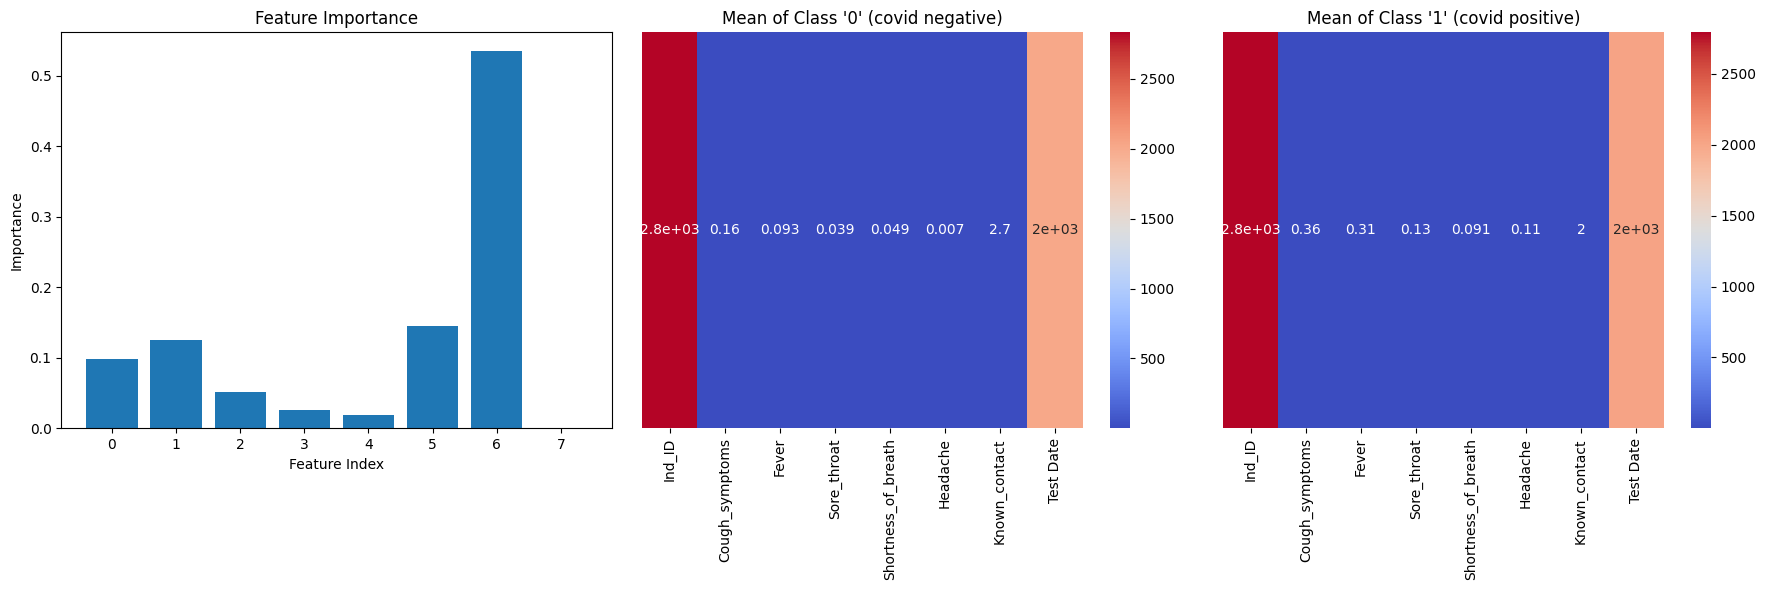

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

# Example feature_importance (assuming it is a torch tensor from your model)
# You need to replace this with actual feature importance from your model
#feature_importance = torch.rand(13)  # Assuming 13 features in the heart dataset

# Detach if required and convert to numpy array
feature_importance = feature_importance1.detach().numpy()

# Assuming X is the feature matrix and y is the target
# Replace X and y with actual data from your heart dataset
# For example, X_train, y_train from the split step
mean_no_disease = X[y == 0].mean(axis=0)  # Mean of class '0' (no heart disease)
mean_disease = X[y == 1].mean(axis=0)     # Mean of class '1' (heart disease)

# Plot the feature importance and class means
plt.figure(figsize=(18, 6))

# Plot 1: Feature Importance as a bar plot
plt.subplot(1, 3, 1)
plt.title("Feature Importance")
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.xticks(np.arange(len(feature_importance)))

# Plot 2: Mean of Class '0' (No Heart Disease) as a heatmap
plt.subplot(1, 3, 2)
plt.title("Mean of Class '0' (covid negative)")
sns.heatmap(mean_no_disease.reshape(1, -1), cmap='coolwarm', annot=True, cbar=True, xticklabels=data.columns[:-1])
plt.yticks([])

# Plot 3: Mean of Class '1' (Heart Disease) as a heatmap
plt.subplot(1, 3, 3)
plt.title("Mean of Class '1' (covid positive)")
sns.heatmap(mean_disease.reshape(1, -1), cmap='coolwarm', annot=True, cbar=True, xticklabels=data.columns[:-1])
plt.yticks([])

# Show the plots
plt.tight_layout()
plt.show()


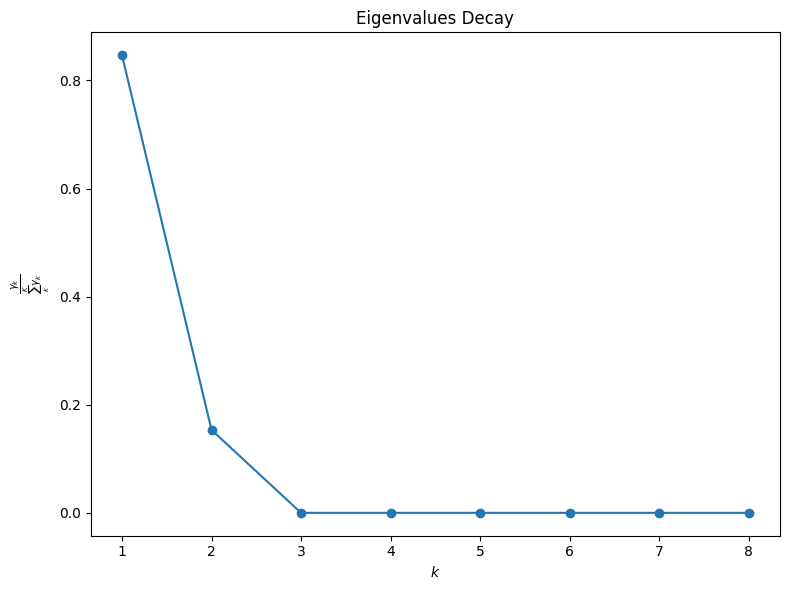

In [ ]:
# Plot eigenvalues decay
gammas = eigenvalues.detach().numpy()[::-1] # sort eigenvalues
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(gammas) + 1), gammas / np.sum(gammas), marker='o', linestyle='-')
plt.xlabel('$k$')
plt.title("Eigenvalues Decay")
plt.ylabel(r'$\frac{\gamma_k}{\sum_k^K \gamma_k}$')
plt.tight_layout()
plt.show()

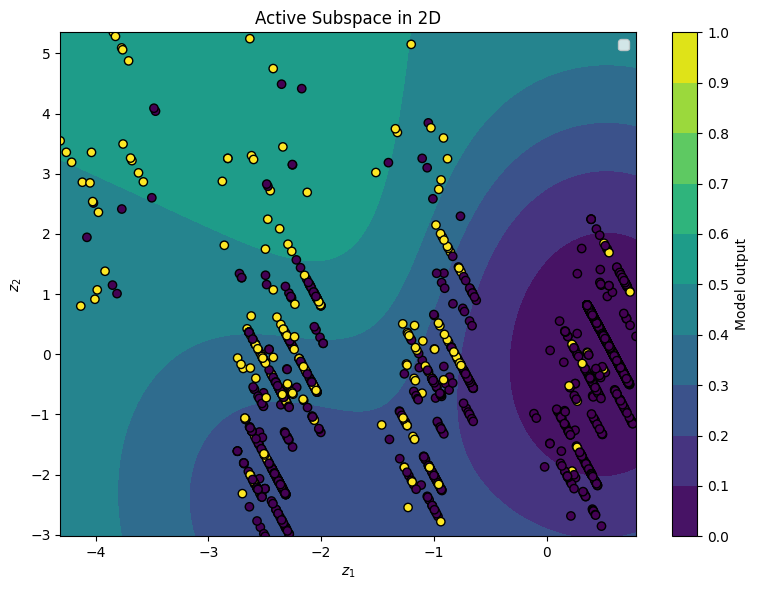

In [ ]:
# Plot contours

V = eigenvectors.detach().numpy()[:, ::-1] # sort eigenvectors
Z = np.dot(X_train_st, V[:, :2]) # project data into the latent or active subspace defined by the top-2 eigenvectors

lb1, ub1 = min(Z[:, 0]), max(Z[:, 0])
lb2, ub2 = min(Z[:, 1]), max(Z[:, 1])
xx1 = np.linspace(lb1, ub1, 100)
xx2 = np.linspace(lb2, ub2, 100)

XX1, XX2 = np.meshgrid(xx1, xx2)
xx12 = np.vstack([XX1.ravel(), XX2.ravel()]).T
xx12_back = np.dot(xx12, V[:, :2].T) # reproject back data from the active subspace so that we can evaluate the model
xx12_back = torch.tensor(xx12_back, dtype=torch.float32)

XX3 = model(xx12_back).detach().numpy().reshape(XX1.shape) # obtan the model output


fig, ax = plt.subplots(figsize=(8, 6))
# Plot centers
centers_projected = np.dot(model.centers.detach().numpy(), V[:, :2])

contours = plt.contourf(XX1, XX2, XX3, cmap='viridis', levels=np.linspace(0, 1, 11))
cbar = plt.colorbar(contours)
cbar.set_label('Model output')
cbar.set_ticks(np.linspace(0, 1, 11))

plt.scatter(Z[:, 0], Z[:, 1], c=y_train, edgecolors='black')
#plt.scatter(centers_projected[:, 0], centers_projected[:, 1], c='red', marker='x', label='Centers')

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
plt.title('Active Subspace in 2D')
plt.legend()
plt.tight_layout()